# Case study - lokalizacja Wi-Fi

W folderze UJIndoorLoc znajdziecie pliki z danymi dotyczącymi lokalizacji w budynku na podstawie sygnałów z sieci WiFi. Problem jest o tyle ciekawy, że o ile lokalizacja na zewnątrz jest problemem prostym do rozwiązania (dobra jakość sygnału GPS), tak wewnątrz budynku jest już trudniej.

Jednym z proponowanych rozwiązań jest użycie mocy sygnału WiFi z punktów dostępu rozlokowanych wewnątrz budynku. Sygnał ten jednak jest na tyle niestabilny, że ciężko deterministycznie określić na jego podstawie dokładne położenie. Na szczęście z pomocą przychodzi machine learning!  

Waszym zadaniem jest skonstruowanie algorytmu, który będzie określał położenie użytkownika (tzn wysokość i szerokość geograficna oraz numer piętra) na podstawie wejściowych danych. Zależy nam zarówno na wysokiej skuteczności, jak i na szybkim czasie predykcji. 

Opis danych: https://archive.ics.uci.edu/ml/datasets/ujiindoorloc

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
train_data = pd.read_csv('./UJIndoorLoc/UJIndoorLoc/trainingData.csv')

In [28]:
test_data = pd.read_csv('./UJIndoorLoc/UJIndoorLoc/validationData.csv')

In [29]:
train_data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [30]:
test_data['BUILDINGID'].value_counts()

0    536
1    307
2    268
Name: BUILDINGID, dtype: int64

In [31]:
train_data['BUILDINGID'].value_counts()

2    9492
0    5249
1    5196
Name: BUILDINGID, dtype: int64

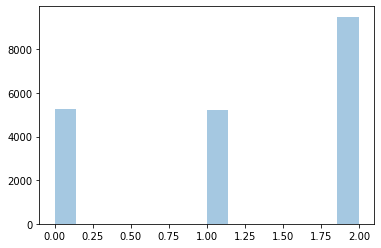

In [34]:
sns.distplot(train_data[['BUILDINGID']],kde=False)
plt.show()

In [41]:
np.unique(train_data['BUILDINGID'])

array([0, 1, 2], dtype=int64)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


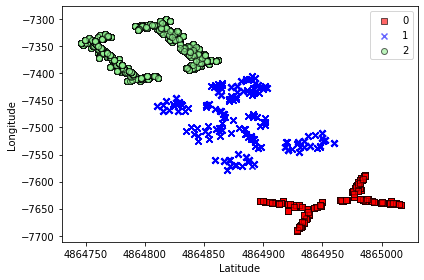

In [47]:
from matplotlib.colors import ListedColormap
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(train_data['BUILDINGID']))])

for idx, cl in enumerate(np.unique(train_data['BUILDINGID'])):
        plt.scatter(x=train_data.loc[train_data.BUILDINGID== cl]['LATITUDE'], 
                    y=train_data.loc[train_data.BUILDINGID== cl]['LONGITUDE'],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

<img src="http://www.analyzingdata.org/Wf-gmap.png" width="550">


## Uczymy na budynku nr 0.

In [43]:
X_train = train_data[train_data['BUILDINGID']==0]
X_test = test_data[test_data['BUILDINGID']==0]

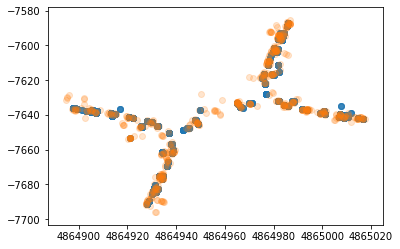

In [51]:
plt.scatter(x=X_train['LATITUDE'], y=X_train['LONGITUDE'], alpha=0.2)
plt.scatter(x=X_test['LATITUDE'], y=X_test['LONGITUDE'], alpha=0.2)
plt.show()

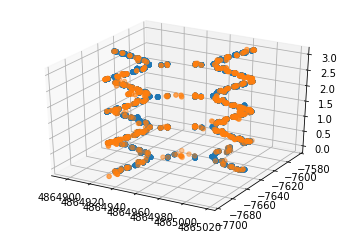

In [54]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train['LATITUDE'], X_train['LONGITUDE'], X_train['FLOOR'])
ax.scatter(X_test['LATITUDE'], X_test['LONGITUDE'], X_test['FLOOR'])

plt.show()

# Mamy missing data

WAP001-WAP520: Intensity value for Wireless Access Point (WAP). WAP will be the acronym used for rest of this notebook. Negative integer values from -104 to 0 and +100. Censored data: Positive value 100 used if WAP was not detected.

In [55]:
X_train = (X_train
             .replace(to_replace=100,value=np.nan))

# Perform the same transform on Test data
X_test = (X_test
             .replace(to_replace=100,value=np.nan))

In [56]:
X_train.isnull().sum()

WAP001              5231
WAP002              5230
WAP003              5249
WAP004              5249
WAP005              5249
WAP006              5249
WAP007              4671
WAP008              5128
WAP009              4654
WAP010              5249
WAP011              5249
WAP012              5249
WAP013              3274
WAP014              3294
WAP015              5249
WAP016              5249
WAP017              5168
WAP018              5162
WAP019              4831
WAP020              4859
WAP021              5249
WAP022              5249
WAP023              4531
WAP024              4523
WAP025              4618
WAP026              4594
WAP027              4531
WAP028              4494
WAP029              3767
WAP030              3718
                    ... 
WAP500              5145
WAP501              5249
WAP502              5249
WAP503              5249
WAP504              5249
WAP505              5249
WAP506              5249
WAP507              5249
WAP508              5236


In [12]:
X_train.head(10)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710
7119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7637.2570,4.864950e+06,0,0,102,2,11,13,1369908951
7120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7628.1345,4.864977e+06,0,0,110,2,11,13,1369909107
7121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7622.0546,4.864976e+06,0,0,111,2,11,13,1369909166
7122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7636.2057,4.864967e+06,0,0,107,2,11,13,1369909011
7123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7633.7295,4.864965e+06,0,0,106,2,11,13,1369909056
7124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7605.4193,4.864979e+06,0,0,115,2,11,13,1369909334
7125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7607.2476,4.864979e+06,0,0,114,2,11,13,1369909296
7126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7616.5560,4.864976e+06,0,0,113,2,11,13,1369909254
7127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7618.5869,4.864975e+06,0,0,112,2,11,13,1369909217


# Zad
1. Zbuduj model dla przewidzenia pietra budynku.
2. Następnie wyznacz połozenie.

* rozwiąż problem missing data 
* wykonaj standaryzacja danych
* selekcja cech (doczytaj co robi ponizsz funkcj i użyj jej)
  ```python
  from sklearn.feature_selection import VarianceThreshold
  ```
* redukcja wymiarowości
* zbudować model 
  * - na piętro - klasyfikacja, 
  * - długość i szerokość - regresja
* przetestować na zbiorze testowym
* wykonaj rysunek

In [92]:
y_lon_train = X_train['LONGITUDE'].values
y_lat_train = X_train['LATITUDE'].values
y_floor_train = X_train['FLOOR'].values

y_lon_test = X_test['LONGITUDE'].values
y_lat_test = X_test['LATITUDE'].values
y_floor_test = X_test['FLOOR'].values

In [58]:
cols_to_train = [i for i in train_data.columns if 'WAP' in i]
print(cols_to_train)

['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007', 'WAP008', 'WAP009', 'WAP010', 'WAP011', 'WAP012', 'WAP013', 'WAP014', 'WAP015', 'WAP016', 'WAP017', 'WAP018', 'WAP019', 'WAP020', 'WAP021', 'WAP022', 'WAP023', 'WAP024', 'WAP025', 'WAP026', 'WAP027', 'WAP028', 'WAP029', 'WAP030', 'WAP031', 'WAP032', 'WAP033', 'WAP034', 'WAP035', 'WAP036', 'WAP037', 'WAP038', 'WAP039', 'WAP040', 'WAP041', 'WAP042', 'WAP043', 'WAP044', 'WAP045', 'WAP046', 'WAP047', 'WAP048', 'WAP049', 'WAP050', 'WAP051', 'WAP052', 'WAP053', 'WAP054', 'WAP055', 'WAP056', 'WAP057', 'WAP058', 'WAP059', 'WAP060', 'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066', 'WAP067', 'WAP068', 'WAP069', 'WAP070', 'WAP071', 'WAP072', 'WAP073', 'WAP074', 'WAP075', 'WAP076', 'WAP077', 'WAP078', 'WAP079', 'WAP080', 'WAP081', 'WAP082', 'WAP083', 'WAP084', 'WAP085', 'WAP086', 'WAP087', 'WAP088', 'WAP089', 'WAP090', 'WAP091', 'WAP092', 'WAP093', 'WAP094', 'WAP095', 'WAP096', 'WAP097', 'WAP098', 'WAP099', 'WAP100',

In [103]:
y_lat_train

array([4864982.2171, 4864949.8143, 4864977.0212, ..., 4864932.3486,
       4864948.8147, 4864947.852 ])

In [134]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

preprocessing_pipeline_classification = Pipeline([
    ("select_cat", DataFrameSelector(cols_to_train)),
    ("imputer", SimpleImputer(strategy="median")),
    ('data scaling', MinMaxScaler()),
    ('remove zero variance', VarianceThreshold()),
    ('dimention reduction', PCA(100))
])


preprocessing_pipeline_regression = Pipeline([
    ("select_cat", DataFrameSelector(cols_to_train)),
    ("imputer", SimpleImputer(strategy="median")),
    ('data scaling', MinMaxScaler()),
    ('remove zero variance', VarianceThreshold()),
    ('dimention reduction', PCA(100))
])


In [80]:
XX= preprocessing_pipeline_classification.fit_transform(X_train, y_floor_train)
XX.shape

(5249, 100)

In [122]:
XX= preprocessing_pipeline_regression.fit_transform(X_train, y_floor_train)
XX.shape

(5249, 100)

In [168]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


seed=123
kfold_floor = StratifiedKFold(n_splits=5, random_state=seed)
seed=123
kfold_lon = KFold(n_splits=5, random_state=seed)

pipe_floor = Pipeline([
    ('preprocessing', preprocessing_pipeline_classification), 
    ('classifier', KNeighborsClassifier())])
param_floor_grid = {
            'classifier__n_neighbors': [5, 10, 20, 100]
}
grid_floor_1 = GridSearchCV(pipe_floor, param_floor_grid, cv=kfold_floor)
grid_floor_1.fit(X_train, y_floor_train)
grid_floor_1.best_params_


pipe_lon_1 = Pipeline([
    ('preprocessing', preprocessing_pipeline_regression), 
    ('regression', KNeighborsRegressor())])


param_lon_grid = {
            'regression__n_neighbors': [5, 10, 20, 100]
}
grid_lon_1 = GridSearchCV(pipe_lon_1, param_lon_grid, cv=kfold_lon)
grid_lon_1.fit(X_train, y_lon_train)
grid_lon_1.best_params_



pipe_lat_1 = Pipeline([
    ('preprocessing', preprocessing_pipeline_regression), 
    ('regression', KNeighborsRegressor())])


param_lat_grid = {
            'regression__n_neighbors': [5, 10, 20, 100]
}
grid_lat_1 = GridSearchCV(pipe_lat_1, param_lat_grid, cv=kfold_lon)
grid_lat_1.fit(X_train, y_lat_train)
grid_lat_1.best_params_

{'regression__n_neighbors': 5}

In [173]:
X_test[:1]

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774


In [178]:
x1 = X_test[:1]
flor = grid_floor_1.best_estimator_.predict(x1)
lon = grid_lon_1.best_estimator_.predict(x1)
lat = grid_lat_1.best_estimator_.predict(x1)

print("Flor = ", flor)
print("LATITUDE , LONGITUDE = ", lat, " ",lon )

print("Flor = ", x1['FLOOR'].values)
print("LATITUDE , LONGITUDE = ", x1['LATITUDE'].values, " ",x1['LONGITUDE'].values )

Flor =  [3]
LATITUDE , LONGITUDE =  [4864904.70462]   [-7637.15038]
Flor =  [2]
LATITUDE , LONGITUDE =  [4864922.39917781]   [-7641.49930337]


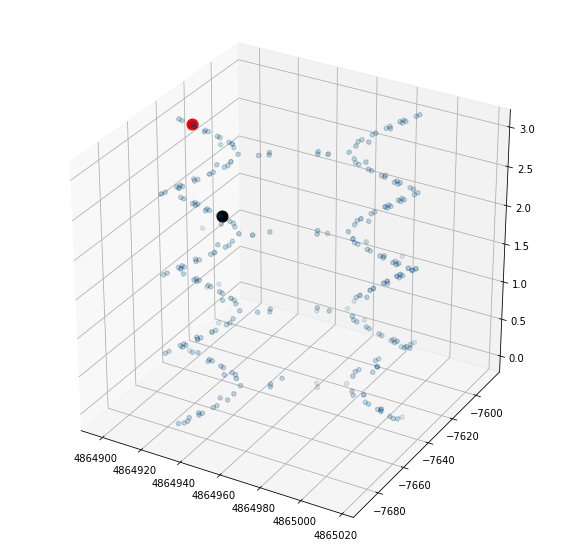

In [179]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train['LATITUDE'], X_train['LONGITUDE'], X_train['FLOOR'], alpha =0.01)
ax.scatter(lat, lon, flor, s=120, c="red")
ax.scatter(x1['LATITUDE'], x1['LONGITUDE'], x1['FLOOR'].values, s=120, c="black")
# ax.scatter(X_test['LATITUDE'], X_test['LONGITUDE'], X_test['FLOOR'])

plt.show()